# Analysis of HD32313 data

In [1]:
import os
import copy
import wget
import time
import asyncio
import warnings
import logging

import numpy as np
from pathlib import Path

from astropy.io import fits
from astropy.modeling import models, fitting

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter

from matplotlib import pyplot as plt

from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

plt.rcParams['figure.figsize'] = [7, 6]

%matplotlib inline

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
class DonutHandler:
    def __init__(self):
        
        self.data_folder = Path("/home/saluser/data/")
        self.output_folder = Path("/home/saluser/data/output")

        self.intra_fnames = []
        self.extra_fnames = []
        
        self.intra_exposures = []
        self.extra_exposures = []

        # I1/I2 get modified down below, so reset here
        self.I1 = []
        self.I2 = []

        self.zern = []

        # Select where your object is, but ours will be on-axis
        self.fieldXY = [0.0,0.0]

        self.ceny = 350 #round(im_shape[0]/2)
        self.cenx = 450 # round(im_shape[1]/2)
        
        self.pre_side = 300
        self.side = 150
        
    @property
    def ndata(self):
        return len(self.intra_fnames)
    
    def set_intra_extra(self, intra, extra):
        
        self.intra_fnames = intra
        self.extra_fnames = extra
        
        for i in range(self.ndata):
            self.intra_exposures.append((fits.open(self.data_folder / intra_fnames[i]))[0].data)
            self.extra_exposures.append((fits.open(self.data_folder / extra_fnames[i]))[0].data)

    def center_and_cut_image(self, index, side=400, manual=False):
        
        intra_exp = self.intra_exposures[index]
        extra_exp = self.extra_exposures[index]

        if not manual:
            print("Automatic centering")
            im_shape=intra_exp.shape
            im_filtered = medfilt(intra_exp+extra_exp,[3,3])
            im_filtered -= int(np.median(im_filtered))
            mean = np.mean(im_filtered)
            # iter 1
            ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
            print(ceny, cenx)
            # iter 2
            intra_square = intra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                     cenx-self.pre_side:cenx+self.pre_side] 
            extra_square = extra_exp[ceny-self.pre_side:ceny+self.pre_side, 
                                     cenx-self.pre_side:cenx+self.pre_side]
            print(intra_square.shape, extra_square.shape)
            im = (intra_square+extra_square)
            im_filtered = medfilt(im,[3,3])
            im_filtered -= int(np.median(im_filtered))
            mean = np.mean(im_filtered)
            im_filtered[im_filtered < mean] = 0.
            im_filtered[im_filtered > mean] = 1.
            # iter 1
            cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
            print(cy2-self.pre_side, cx2-self.pre_side)    
            ceny += (cy2-self.pre_side)
            cenx += (cx2-self.pre_side)
        else:
            print("Manual centering")
            ceny=self.ceny #round(im_shape[0]/2)
            cenx=self.cenx # round(im_shape[1]/2)
        side=self.side # side length of image
        print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
        im_shape=intra_exp.shape
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

        return intra_square, extra_square
    
    def create_images(self):
        
        for i in range(self.ndata):
            i1, i2 = self.center_and_cut_image(i)
            self.I1.append(Image(i1, self.fieldXY, Image.INTRA))
            self.I2.append(Image(i2, self.fieldXY, Image.EXTRA))

    def run_algo(self):
        # Declare instrument
        self.inst = Instrument('auxtel',donut_handler.I1[0].sizeinPix)
        hex_to_focus_scale = 41.0
        offset=1.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
        pixelsize = 3.6e-6*4 # 4 is the binning
        # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

        print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
        print('Offset in file is :{} [mm] at the focus'.format(1e3*self.inst.offset))
        print('pixelSize should be: {}'.format(pixelsize))

        #declare algorithm
        # declare algorithm - exponential solver.
        self.algo = Algorithm('exp', self.inst, 1) # example     
        
        for i in range(self.ndata):
            self.algo.reset(donut_handler.I1[i], donut_handler.I2[i])

            self.algo.runIt(self.inst,donut_handler.I1[i],donut_handler.I2[i],'onAxis')
            
            self.zern.append(self.algo.zer4UpNm[0:9])


In [3]:
data_folder = Path("/home/saluser/data/")
output_folder = Path("/home/saluser/data/output")

## Dataset 1:

El: ??. -- about ??:?? UTC

Extra-focal filename: 1576286733-HD32313-0-1.fits

Intra-focal filename: 1576286665-HD32313-0-1.fits

In [4]:
intra_fname_1 = "1576286665-HD32313-0-1.fits"
extra_fname_1 = "1576286733-HD32313-0-1.fits"

In [23]:
intra_fname_2 = "1576287165-HD32313-0-1.fits"
extra_fname_2 = "1576287233-HD32313-0-1.fits"

In [24]:
intra_fnames = [intra_fname_1, intra_fname_2]
extra_fnames = [extra_fname_1, extra_fname_2]

In [25]:
donut_handler = DonutHandler()

In [26]:
donut_handler.set_intra_extra(intra_fnames, extra_fnames)

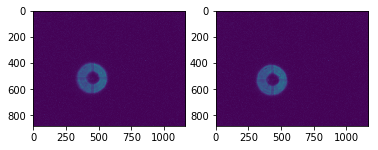

In [27]:
fig = plt.figure()

for i in range(donut_handler.ndata):
    sub = fig.add_subplot(1, donut_handler.ndata, 1+i)
    sub.imshow(donut_handler.intra_exposures[i]+donut_handler.extra_exposures[i])

In [28]:
donut_handler.create_images()

Automatic centering
496 429
(600, 600) (600, 600)
20 17
Creating stamps of centroid [y,x] = [516,446] with a side length of 150 pixels
Automatic centering
515 401
(600, 600) (600, 600)
17 22
Creating stamps of centroid [y,x] = [532,423] with a side length of 150 pixels


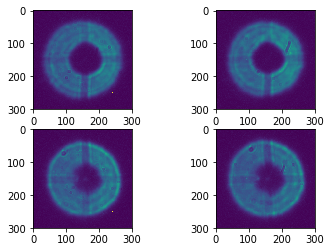

In [29]:
fig = plt.figure()

for i in range(donut_handler.ndata):
    sub1 = fig.add_subplot(2, donut_handler.ndata, 1+i)
    sub1.imshow(donut_handler.I1[i].image)

    sub2 = fig.add_subplot(2, donut_handler.ndata, donut_handler.ndata+1+i)
    sub2.imshow(donut_handler.I2[i].image)


In [30]:
donut_handler.run_algo()

Offset should be :61.5 [mm] at the focus, 1.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


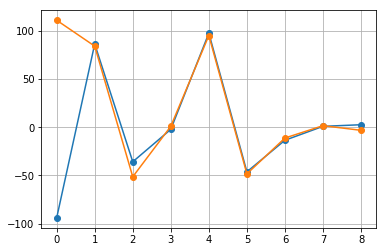

In [31]:
for i in range(donut_handler.ndata):
    plt.plot(donut_handler.zern[i], 'o-')
plt.grid()

In [ ]:
# Plot images with masks to check mapping is correct
# I think these plot residuals, but I1.image0 plots the original image
# plots.plotImage(donut_handler.I1[3].image0,'intra', mask=algo.pMask) 
plots.plotImage(donut_handler.I1[0].image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(donut_handler.I2[0].image,'extra', mask=algo.pMask)